In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deeplearningproject5/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9490196523666382].


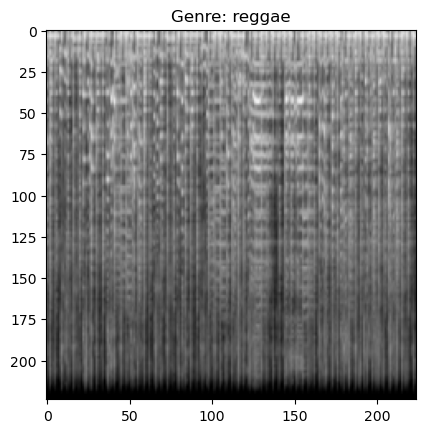

In [5]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Custom GTZAN Dataset class
class GTZANDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.genres = sorted(os.listdir(root_dir))
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        self.data = []
        for genre in self.genres:
            genre_dir = os.path.join(root_dir, genre)
            for filename in os.listdir(genre_dir):
                if filename.endswith('.wav'):
                    self.data.append((os.path.join(genre_dir, filename), self.genre_to_idx[genre]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path, label = self.data[idx]
        y, sr = librosa.load(audio_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Convert to 3-channel image for VGG16
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())  # Normalize to [0, 1]
        mel_spec_rgb = np.stack([mel_spec_db] * 3, axis=-1)  # [H, W, 3]
        image = Image.fromarray((mel_spec_rgb * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load dataset (download from Kaggle manually first)
data_dir = './data/genres_original'  # Extract GTZAN genres_original folder here
dataset = GTZANDataset(root_dir=data_dir, transform=transform)

# Train/validation/test split (70/15/15)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a sample
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title(f'Genre: {dataset.genres[labels[0].item()]}')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9333333966732026].


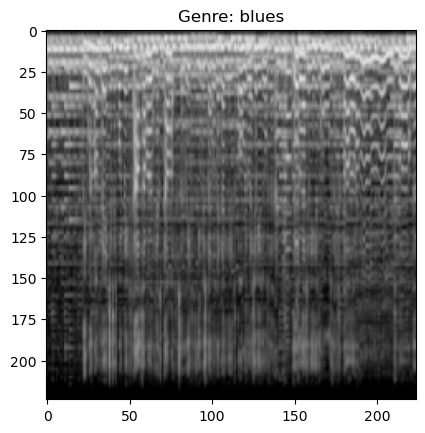

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Custom GTZAN Dataset class
class GTZANDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.genres = sorted(os.listdir(root_dir))
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        self.data = []
        for genre in self.genres:
            genre_dir = os.path.join(root_dir, genre)
            for filename in os.listdir(genre_dir):
                if filename.endswith('.wav'):
                    self.data.append((os.path.join(genre_dir, filename), self.genre_to_idx[genre]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path, label = self.data[idx]
        y, sr = librosa.load(audio_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Convert to 3-channel image for VGG16
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())  # Normalize to [0, 1]
        mel_spec_rgb = np.stack([mel_spec_db] * 3, axis=-1)  # [H, W, 3]
        image = Image.fromarray((mel_spec_rgb * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Check for dataset and guide download if missing
data_dir = './data/genres_original'
if not os.path.exists(data_dir):
    raise FileNotFoundError(
        f"Directory '{data_dir}' not found. Please download the GTZAN dataset from "
        "https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification, "
        "extract the 'genres_original' folder from 'genres_original.zip', and place it in "
        "'./data/genres_original/' within the Project5_MusicGenreClassification directory."
    )

# Load dataset
dataset = GTZANDataset(root_dir=data_dir, transform=transform)

# Train/validation/test split (70/15/15)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a sample
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title(f'Genre: {dataset.genres[labels[0].item()]}')
plt.show()

/var/folders/5k/98s1prfj6zjgkscx_x64q9cm0000gn/T/ipykernel_54718/2687711945.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050)
/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping ./data/genres_original/jazz/jazz.00054.wav: 
Total skipped files: 1


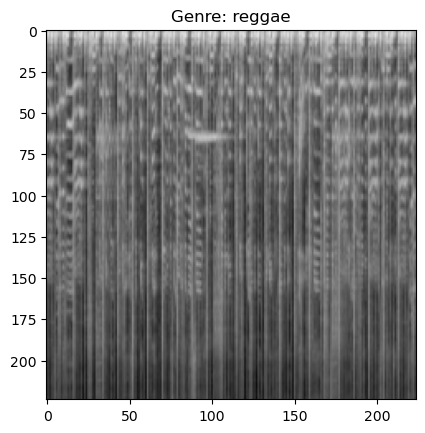

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom GTZAN Dataset class with error handling
class GTZANDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.genres = sorted(os.listdir(root_dir))
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        self.data = []
        self.skipped_files = []
        
        for genre in self.genres:
            genre_dir = os.path.join(root_dir, genre)
            for filename in os.listdir(genre_dir):
                if filename.endswith('.wav'):
                    audio_path = os.path.join(genre_dir, filename)
                    # Test if the file can be loaded
                    try:
                        y, sr = librosa.load(audio_path, sr=22050)
                        self.data.append((audio_path, self.genre_to_idx[genre]))
                    except Exception as e:
                        print(f"Skipping {audio_path}: {str(e)}")
                        self.skipped_files.append(audio_path)

        if self.skipped_files:
            print(f"Total skipped files: {len(self.skipped_files)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path, label = self.data[idx]
        y, sr = librosa.load(audio_path, sr=22050)  # Already validated, should work
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Convert to 3-channel image for VGG16
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())  # Normalize to [0, 1]
        mel_spec_rgb = np.stack([mel_spec_db] * 3, axis=-1)  # [H, W, 3]
        image = Image.fromarray((mel_spec_rgb * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Check for dataset and guide download if missing
data_dir = './data/genres_original'
if not os.path.exists(data_dir):
    raise FileNotFoundError(
        f"Directory '{data_dir}' not found. Please download the GTZAN dataset from "
        "https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification, "
        "extract the 'genres_original' folder from 'genres_original.zip', and place it in "
        "'./data/genres_original/' within the Project5_MusicGenreClassification directory."
    )

# Load dataset
dataset = GTZANDataset(root_dir=data_dir, transform=transform)

# Train/validation/test split (70/15/15)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a sample
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title(f'Genre: {dataset.genres[labels[0].item()]}')
plt.show()

In [9]:
# Load pre-trained VGG16
model = torchvision.models.vgg16(pretrained=True)

# Freeze convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10)  # 10 genres
)

model = model.to(device)

/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/deeplearningproject5/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Phase 1 Epoch [1/5], Train Loss: 1.9955, Val Loss: 1.3527
Phase 1 Epoch [2/5], Train Loss: 1.2574, Val Loss: 1.1782
Phase 1 Epoch [3/5], Train Loss: 1.0256, Val Loss: 0.9969
Phase 1 Epoch [4/5], Train Loss: 0.7921, Val Loss: 0.9673
Phase 1 Epoch [5/5], Train Loss: 0.6178, Val Loss: 1.0782
Phase 2 Epoch [1/5], Train Loss: 0.4656, Val Loss: 1.0276
Phase 2 Epoch [2/5], Train Loss: 0.3464, Val Loss: 1.1035
Phase 2 Epoch [3/5], Train Loss: 0.2924, Val Loss: 1.0943
Phase 2 Epoch [4/5], Train Loss: 0.2561, Val Loss: 0.9964
Phase 2 Epoch [5/5], Train Loss: 0.2458, Val Loss: 1.0507


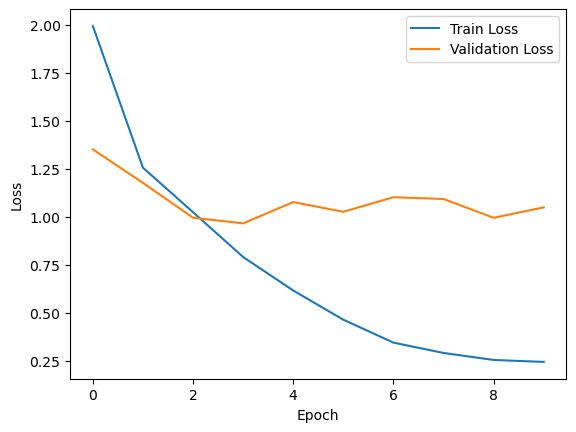

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)  # Only train classifier initially

# Training loop (Phase 1: Train classifier)
num_epochs_phase1 = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs_phase1):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Phase 1 Epoch [{epoch+1}/{num_epochs_phase1}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Phase 2: Unfreeze some layers and fine-tune
for param in model.features[-4:].parameters():  # Unfreeze last conv block
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Lower LR for fine-tuning
num_epochs_phase2 = 5

for epoch in range(num_epochs_phase2):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Phase 2 Epoch [{epoch+1}/{num_epochs_phase2}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 77.48%
